# Weights statistics in neural network

The goal of this notebook is to investigate the statistics of the weights in a neural network during training. 
This is inspired from this Andrej Karpathy's [video](https://www.youtube.com/watch?v=P6sfmUTpUmc).
For this small study the default `fit` method of the [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) class cannot be used since we cannot extract gradient information from the trained model. 
Instead, the [`tf.GradienTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) class was used. 
The `tf.GradientTape` allows you to have more control over the steps at work during model training. 

In [67]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Prepare datasets

In [68]:
# load the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], 784))
x_test = x_test.reshape((x_test.shape[0], 784))

In [69]:
# initialize the labeled data
labeled_data = x_train[:10000]/255
labeled_labels = tf.one_hot(y_train[:10000], depth=10)

In [70]:
labeled_data.shape

(10000, 784)

## Create basic model

In [71]:
# define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(784,), activation='relu'),
    tf.keras.layers.Dense(64, input_shape=(784,), activation='relu'),
    tf.keras.layers.Dense(64, input_shape=(784,), activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [73]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.fit(labeled_data, labeled_labels, epochs=10, batch_size=32)

## Test training model with gradient tape

In [52]:
# A class to compute the incremental mean of the accuracy
class IncrementalMean():
    def __init__(self):
        self.count = 0
        self.mean = 0

    def add_value(self, value):
        self.count +=1
        self.mean = (self.mean * (self.count - 1) + value) / self.count

    def get_mean(self):
        return self.mean

In [51]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    pred = model(x)
    loss_value = tf.keras.losses.categorical_crossentropy(y, pred)
  
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  cat_accuracy = tf.keras.metrics.CategoricalAccuracy()
  cat_accuracy.update_state(y, pred)
  accuracy = cat_accuracy.result()
  return loss_value, gradients, accuracy 
  

In [ ]:
def train_data_for_one_epoch(optimizer, batch_size):
  losses = []
  accuracies = []
  num_updates = int(labeled_data.shape[0] / batch_size)
  
  pbar = tqdm(total=num_updates, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')  

  mean_loss = IncrementalMean()
  mean_accuracy = IncrementalMean()

  for i in range(0, num_updates):
    # determine starting and ending slice indexes for the current batch
    start = i * batch_size
    end = start + batch_size
      
    # take a step
    loss_value, gradient, accuracy = apply_gradient(optimizer, model, labeled_data[start:end], labeled_labels[start:end])
      
    mean_loss.add_value(tf.math.reduce_mean(loss_value))
    mean_accuracy.add_value(accuracy)
      
    
    pbar.set_description("Training loss: %.4f - Training accuracy: %.4f" % (mean_loss.get_mean(), mean_accuracy.get_mean()))
    pbar.update()

  return mean_loss.get_mean(), gradient, mean_accuracy.get_mean()

In [64]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
total_loss = []
total_accuracies = []
epochs = 20
for i in range(epochs):
    print(f'Epoch {i+1}/{epochs}')
    loss, grad, accuracies = train_data_for_one_epoch(optimizer=adam, batch_size=32)
    total_loss.append(loss)
    total_accuracies.append(accuracies)

Epoch 1/20


Training loss: 0.0175 - Training accuracy: 0.9944: 100%|██████████████████████████████████████| 312/312 


Epoch 2/20


Training loss: 0.0253 - Training accuracy: 0.9913: 100%|██████████████████████████████████████| 312/312 


Epoch 3/20


Training loss: 0.0116 - Training accuracy: 0.9965: 100%|██████████████████████████████████████| 312/312 


Epoch 4/20


Training loss: 0.0138 - Training accuracy: 0.9949: 100%|██████████████████████████████████████| 312/312 


Epoch 5/20


Training loss: 0.0191 - Training accuracy: 0.9935: 100%|██████████████████████████████████████| 312/312 


Epoch 6/20


Training loss: 0.0183 - Training accuracy: 0.9930: 100%|██████████████████████████████████████| 312/312 


Epoch 7/20


Training loss: 0.0164 - Training accuracy: 0.9952: 100%|██████████████████████████████████████| 312/312 


Epoch 8/20


Training loss: 0.0103 - Training accuracy: 0.9974: 100%|██████████████████████████████████████| 312/312 


Epoch 9/20


Training loss: 0.0076 - Training accuracy: 0.9973: 100%|██████████████████████████████████████| 312/312 


Epoch 10/20


Training loss: 0.0120 - Training accuracy: 0.9956: 100%|██████████████████████████████████████| 312/312 


Epoch 11/20


Training loss: 0.0179 - Training accuracy: 0.9935: 100%|██████████████████████████████████████| 312/312 


Epoch 12/20


Training loss: 0.0203 - Training accuracy: 0.9929: 100%|██████████████████████████████████████| 312/312 


Epoch 13/20


Training loss: 0.0064 - Training accuracy: 0.9977: 100%|██████████████████████████████████████| 312/312 


Epoch 14/20


Training loss: 0.0110 - Training accuracy: 0.9961: 100%|██████████████████████████████████████| 312/312 


Epoch 15/20


Training loss: 0.0089 - Training accuracy: 0.9967: 100%|██████████████████████████████████████| 312/312 


Epoch 16/20


Training loss: 0.0081 - Training accuracy: 0.9973: 100%|██████████████████████████████████████| 312/312 


Epoch 17/20


Training loss: 0.0123 - Training accuracy: 0.9971: 100%|██████████████████████████████████████| 312/312 


Epoch 18/20


Training loss: 0.0140 - Training accuracy: 0.9952: 100%|██████████████████████████████████████| 312/312 


Epoch 19/20


Training loss: 0.0059 - Training accuracy: 0.9987: 100%|██████████████████████████████████████| 312/312 


Epoch 20/20


Training loss: 0.0045 - Training accuracy: 0.9986: 100%|██████████████████████████████████████| 312/312 


In [25]:
model.trainable_weights

[<KerasVariable shape=(784, 64), dtype=float32, path=sequential_1/dense_1/kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=sequential_1/dense_1/bias>,
 <KerasVariable shape=(64, 10), dtype=float32, path=sequential_1/dense_2/kernel>,
 <KerasVariable shape=(10,), dtype=float32, path=sequential_1/dense_2/bias>]

#### Plot loss evolution with respec to epochs

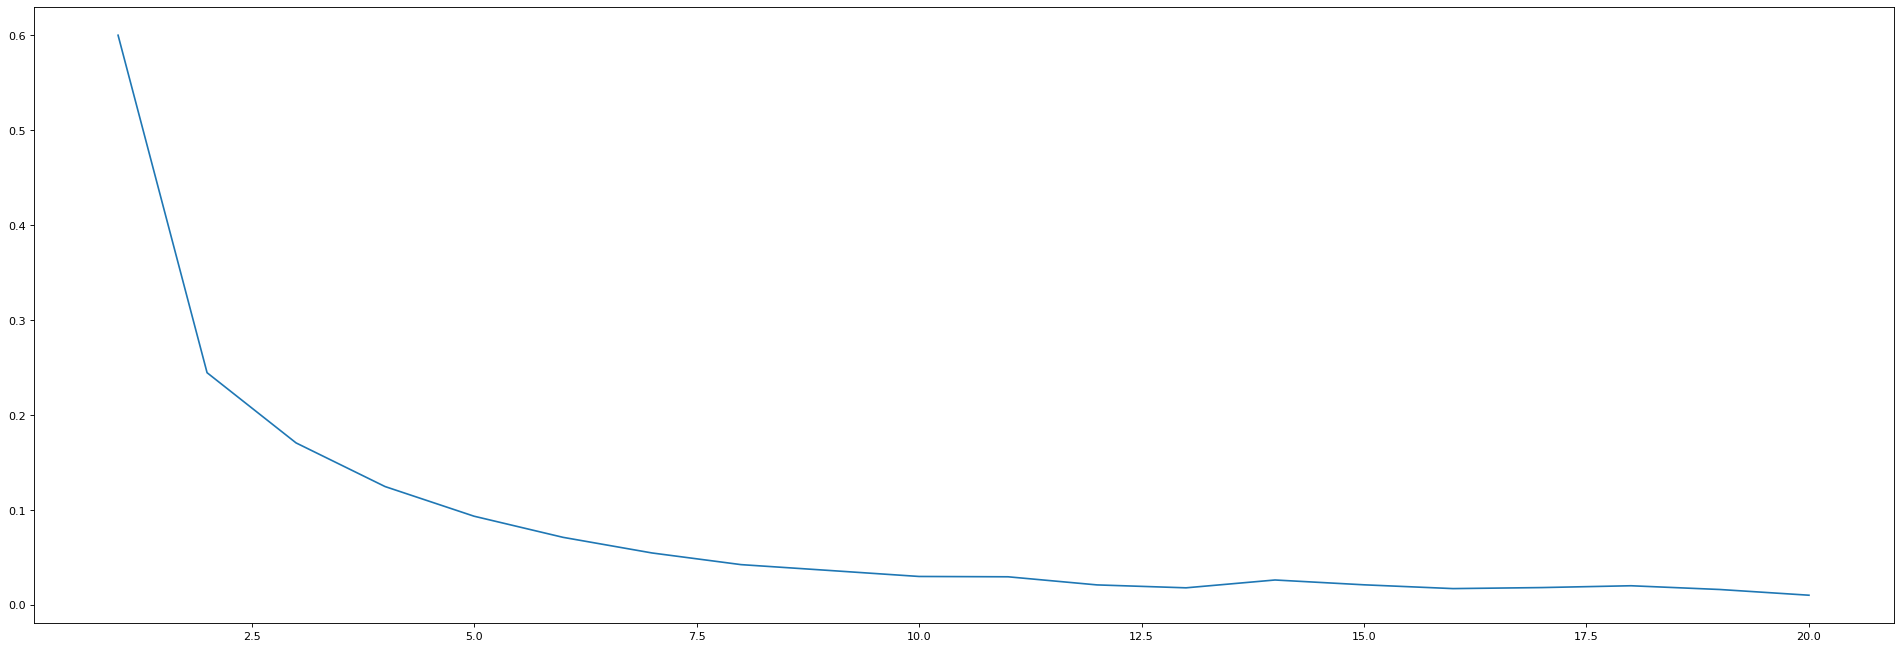

In [55]:
plt.figure(figsize=(30, 10), dpi=80)
plt.plot(list(range(1,len(total_loss)+1)), total_loss)


#### Plot accuracy evolution with respec to epochs

In [56]:
plt.figure(figsize=(30, 10), dpi=80)
plt.plot(list(range(len(total_accuracies))), total_accuracies)


## Checking weights distribution

Text(0.5, 1.0, 'activation distribution')

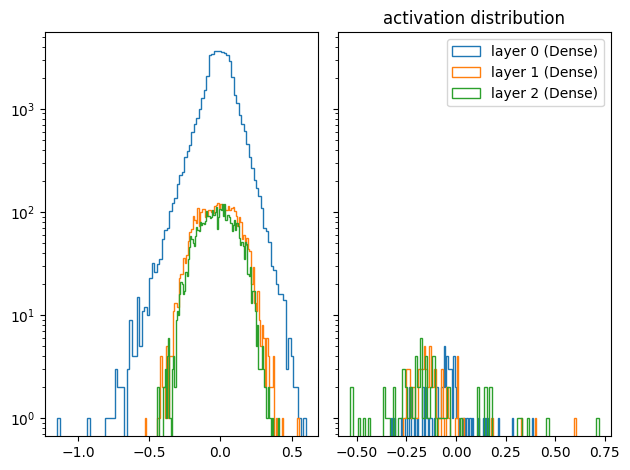

In [80]:
# Checking the distribution of weights and biases
import matplotlib.pyplot as plt

legends = []
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

for i, layer in enumerate(model.layers[:-1]):
    weights = []
    bias = []
    w = layer.get_weights()[0]
    b = layer.get_weights()[1]
    w = tf.reshape(w, (1,w.shape[0]*w.shape[1]))
    axs[0].hist(w, bins=100, density=False,histtype='step')
    axs[1].hist(b, bins=100,density=False,histtype='step')
    plt.yscale('log')
    legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('activation distribution')


### Gradient distribution

Check the distribution of the gradient for a given layer

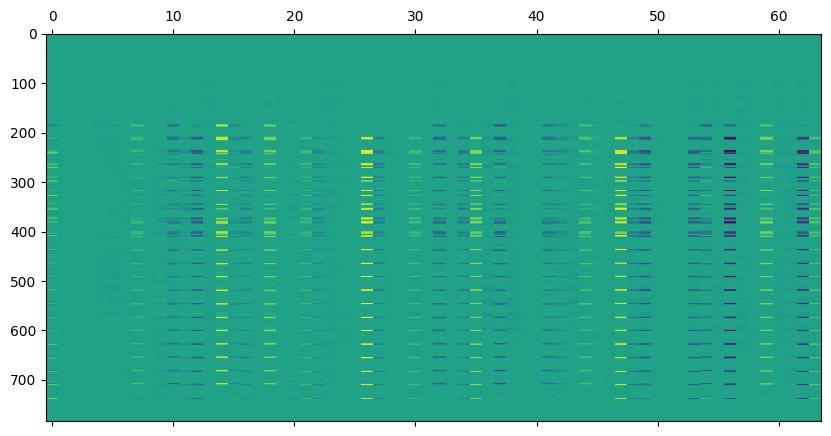

In [74]:
# Plot the gradient of the first layer's weights
plt.figure(figsize=(10,5))
plt.matshow(grad[0], fignum=1, aspect='auto')


### Relative gradient distribution

Computing the relative gradient of each weight. 

Layer #0 - (784, 64) - mean: 0.003711134195327759 | std: 0.7101858854293823
Layer #1 - (64, 64) - mean: -0.002945689484477043 | std: 0.28938737511634827
Layer #2 - (64, 64) - mean: 0.005549676716327667 | std: 0.4027818739414215


Text(0.5, 1.0, 'Relative weight gradient value for all layers')

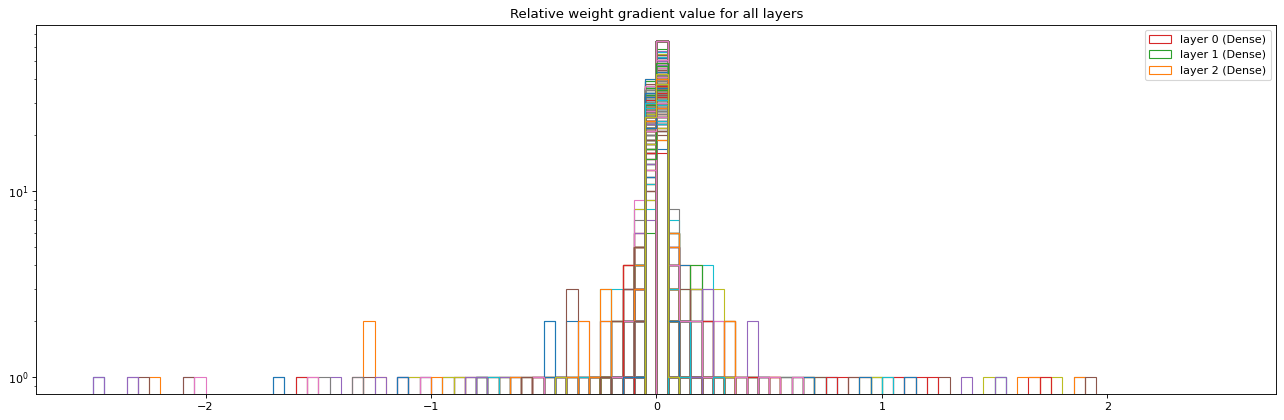

In [101]:
legends = []
figure(figsize=(20, 6), dpi=80)
for layer_number, layer in enumerate(model.layers[:-1]):
    rel_grad = grad[2*layer_number] / layer.get_weights()[0]
    print(f'Layer #{layer_number} - {layer.get_weights()[0].shape} - mean: {np.mean(rel_grad)} | std: {np.std(rel_grad)}')
    plt.hist(rel_grad, bins=100, density=False,histtype='step', range=[-2.5, 2.5])
    plt.yscale('log')
    legends.append(f'layer {layer_number} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('Relative weight gradient value for all layers')